In [1]:
#Import anomaly and mapping scripts
from mapper_clusterer import *
from geography_helper import *
from anomaly_analyzer import AnomalyAnalyzer
from data_cluster_bundle import DataClusterBundle
from pca_analyzer import PcaAnalyzer

#data libraries
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm

#Other imports
import pickle
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import OrdinalEncoder

In [2]:
def feature_grapher(features, dims, c = 'maroon', alpha = .2):
    """
    Displays 3d plot. 
    
    args:
        features: dataframe to plot
        dims: list of 3 indices corresponding to columns to plot
        c: string identifying color or iterable the same length as the features 
        alpha: float specifying alpha
    """
    if len(dims) != 3:
        raise ValueError("Please pass exactly 3 indices")

    colnames = list(features.columns)

    x = features.iloc[:, dims[0]-1]
    y = features.iloc[:, dims[1]-1]
    z = features.iloc[:, dims[2]-1]

    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(x,y,z, c=c, marker="o",alpha=alpha)
    ax.set_title(f"Projection to dimensions {dims}")

    ax.set_xlabel(colnames[dims[0]-1])
    ax.set_ylabel(colnames[dims[1]-1])
    ax.set_zlabel(colnames[dims[2]-1])

    plt.show()

In [3]:
def color_anomalies(aanalyz, anom_color = 'blue', nonanom_color = 'maroon'):
    """
    Given an AnomalyAnalyzer, returns a list of colors the same length as the data. List can be passed to color parameter of plotting functions.
    List items corresponding to anomalies are anom_color, while those corresponding to non-anomalies are nonanom_color.
    
    args:
        aanalyz: AnomalyAnalyzer
        anom_color, nonanom_color: strings or other color identifiers which can be used with a plotter
    returns:
        List of colors the same length as AnomalyAnalyzer data. 
    
    """
    return [*map(lambda x: anom_color if x in list(aanalyz.anomalies['data_idx']) else nonanom_color, list(aanalyz.data.index))]

def alpha_anomalies(aanalyz, anom_alpha = .8, nonanom_alpha = .2):
    """
    Given an AnomalyAnalyzer, returns a list of alpha values the same length as the data. List can be passed to alpha parameter of plotting functions.
    List items corresponding to anomalies are anom_alpha, while those corresponding to non-anomalies are nonanom_alpha.
    
    args:
        aanalyz: AnomalyAnalyzer
        anom_alpha, nonanom_alpha: floats specifying alpha for anomalies and non-anomalies
    returns:
        List of alpha values the same length as AnomalyAnalyzer data. 
    
    """
    return [*map(lambda x: anom_alpha if x in list(aanalyz.anomalies['data_idx']) else nonanom_alpha, list(aanalyz.data.index))]

In [4]:
#Create GA shape file and plottable GeoDataFrame
GA = import_GA_boundary_file('GAboundary.txt')
GApd = gpd.GeoDataFrame(data = pd.DataFrame({'state':['GA']}), geometry = [GA])

In [5]:
#Import original features (pre-impute, scaling, and PCA)
features = pd.read_csv('combined_features.csv', index_col = 0)

In [6]:
#Load PCA object to get loadings, etc.
with open('pca_features_fixed.pickle', 'rb') as f:
    pca = pickle.load(f)
pca_basis = pca.pca.components_.T[:,:5]

In [7]:
#Load local AC model
with open('ac_thresh2p6_cubes20_overlap8.pickle', 'rb') as f:
    ac_local = pickle.load(f)
aa_ac_local = AnomalyAnalyzer(ac_local, features, pca_basis = pca_basis)
aa_ac_local.get_all_anomalies(1, 1, drop_imputed  = True)
print(f'There are {aa_ac_local.anomalies.shape[0]} anomalies with no imputed values.')

There are 156 anomalies with no imputed values.


In [8]:
#Load global no LL model
with open('noLL.pickle', 'rb') as f:
    dcb_noLL = pickle.load(f)

aa_AC_noLL = AnomalyAnalyzer(dcb_noLL, features, pca_basis = pca_basis)
aa_AC_noLL.get_all_anomalies(1,1, drop_imputed = True)

# Local AC

In [9]:
aa_ac_local.get_all_anomalies(1, 1, drop_imputed  = True)
print(f'There are {aa_ac_local.anomalies.shape[0]} anomalies with no imputed values.')

There are 156 anomalies with no imputed values.


In [12]:
# ac_local.export_graph('AC_local.html')

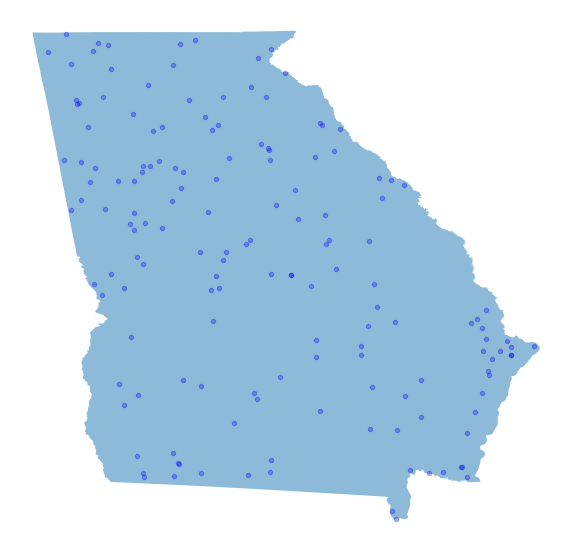

In [11]:
%matplotlib inline
#Plot all anomalies detected by Local AC
aa_ac_local.map_anomalies(GA, markersize = 20, color = 'blue', alpha = .3)

## Visualizing individual clusters

In [12]:
labeled_ac_local = ac_local.data_with_labels()
sizes_ac_local = ac_local.get_cluster_sizes()

(-85.84627525, -80.54184975, 30.1234797, 35.2335803)

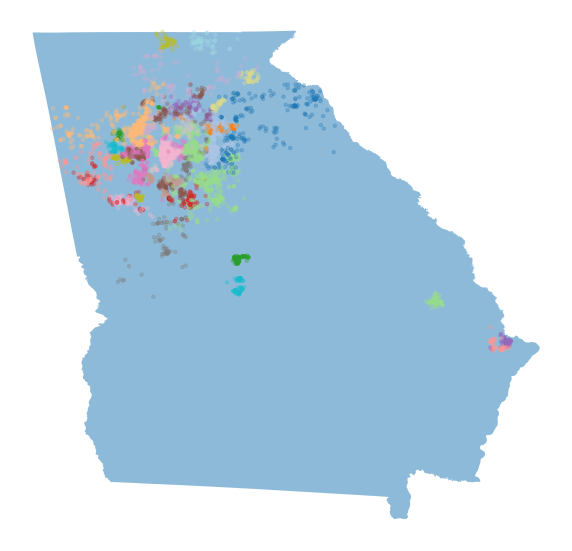

In [13]:
%matplotlib inline
#Plot top 50 largest clusters
n_largest = 50

enc = OrdinalEncoder()
encoded_labels = enc.fit_transform(np.array(labeled_ac_local[labeled_ac_local['cluster']\
                                .isin(sizes_ac_local.iloc[:n_largest, 0])].loc[:,'cluster']).reshape(-1,1)).reshape(-1)

group_colors = cm.tab20(encoded_labels/(n_largest +1))

fig, ax = plt.subplots(figsize = (10,10))
GApd.plot(ax = ax, alpha = .5)
places_to_geom(labeled_ac_local[labeled_ac_local['cluster']\
                                .isin(sizes_ac_local.iloc[:n_largest, 0])])\
                                .plot(ax = ax, markersize = 12, c = group_colors, alpha = .3)

plt.axis('off')

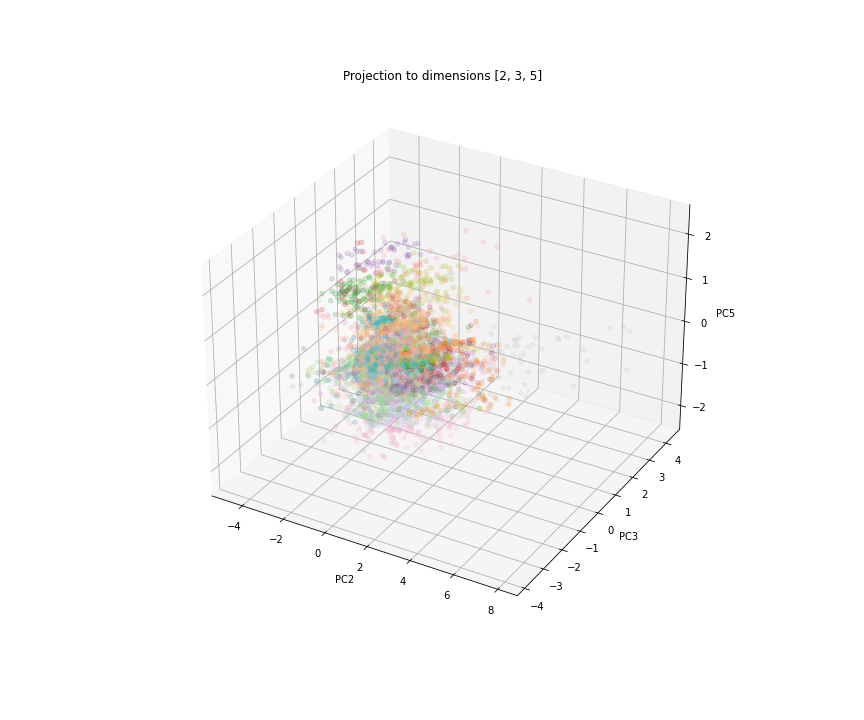

In [14]:
%matplotlib widget
#Plot PCA components colored by cluster for top 50 largest clusters
labeled_ac_local_pca = labeled_ac_local.iloc[:,2:]
feature_grapher(labeled_ac_local_pca[labeled_ac_local_pca['cluster']\
                                .isin(sizes_ac_local.iloc[:n_largest, 0])], [2,3,5], c = group_colors)

## PCA plots

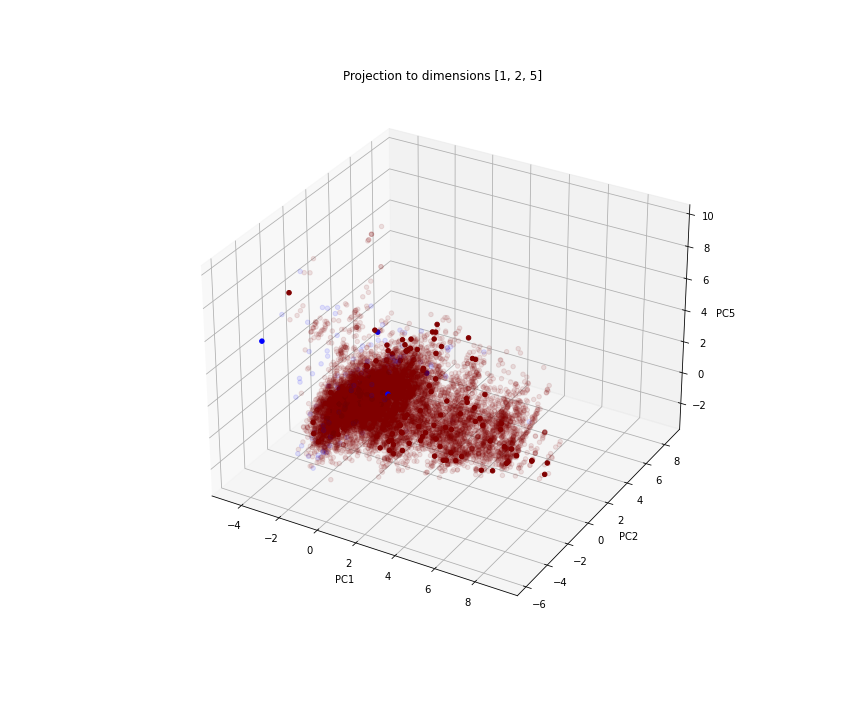

In [15]:
%matplotlib widget
#Plot of PCA components with Local AC anomalies highlighted
feature_grapher(aa_ac_local.data.filter(regex = 'PC'),[1,2,5], 
                c = color_anomalies(aa_ac_local), alpha = alpha_anomalies(aa_ac_local, anom_alpha = 1, nonanom_alpha = .1))

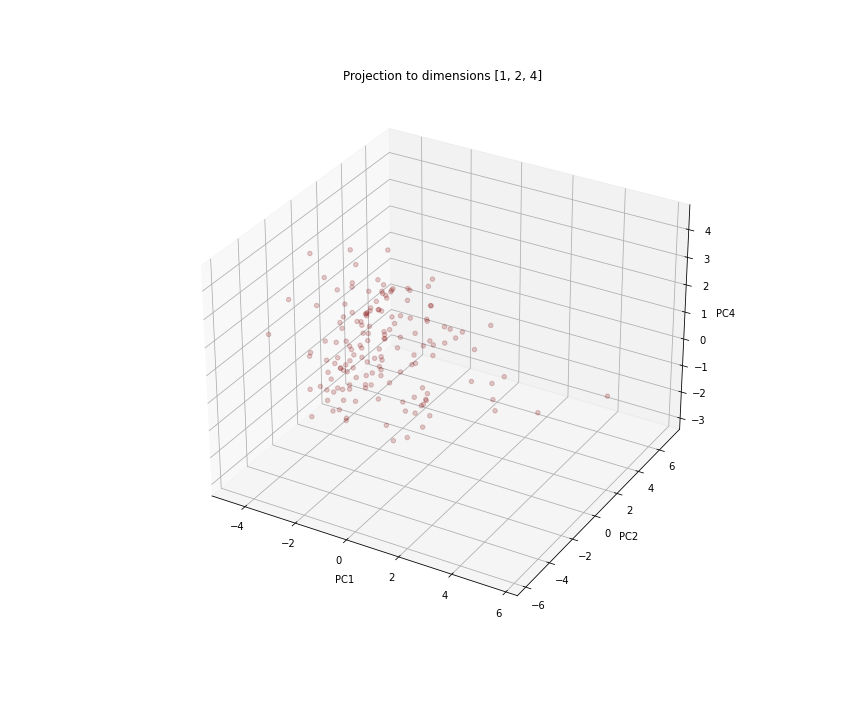

In [16]:
%matplotlib widget
#PCA plot isolating Local AC anomalies
feature_grapher(aa_ac_local.anomalies.filter(regex = 'PC'),[1,2,4])

Many of the anomalies have lower PC1. In fact, they all have PC1 component less than 3.
They also tend to have much lower PC5. However, they are about average in PC2,3,4.

## Anomaly analysis (localized)

In [17]:
%matplotlib inline

In [18]:
#Get the difference between the price of each anomaly and the average price 
#of all houses in the clusters containing the 20 most similar houses
price_comparison_local = pd.DataFrame([*zip(aa_ac_local.anomalies['data_idx'], aa_ac_local.anomalies['data_idx'].apply(lambda x:
    aa_ac_local.compare_price_to_similar(x, n=20)))]).rename({0:'anom_idx', 1:'price_comparison'}, axis = 1)

In [19]:
#Sum of negative differences
price_comparison_local[price_comparison_local.price_comparison<0].loc[:,'price_comparison'].sum()

-39832449.03003995

In [20]:
#Some of positive differences
price_comparison_local[price_comparison_local.price_comparison>0].loc[:,'price_comparison'].sum()

45934675.653207906

In [21]:
anom_cheap = (x for x in aa_ac_local.significantly_cheaper_than_nearby_houses())

In [22]:
%matplotlib inline
#Look at loadings of differences between anomaly features 
#and the mean of clusters containing houses within the default radius (5mi)
n = next(anom_cheap)
print(f'Anomaly index: {n}')
if n in aa_AC_noLL.anomalies['data_idx']:
    print('Anomaly detected by global version.')
else:
    print('Anomaly not detected by global version.')
comparison = aa_ac_local.get_all_loadings(aa_ac_local.dif_from_clusters_in_radius(n))
comparison

Anomaly index: 0
Anomaly detected by global version.
Given point is in cluster 0


cluster,0
square_footage,0.0
posh_total,0.0
dist_to_good_e_school,0.0
property_crime_total_rate,0.0
Transit Score,0.0
num_wb_within_5,0.0
EAL_ratio,0.0
dist_to_transit,0.0
beds,0.0
closest_school_rating,0.0


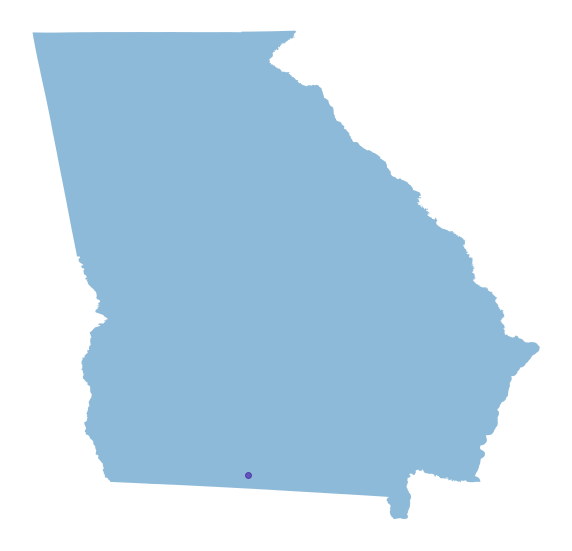

In [23]:
#Look at clusters the anomaly is being compared to
nearby_clusters = list(comparison.columns)
aa_ac_local.map_single_and_clusters(n, nearby_clusters, GA)

In [24]:
places_to_geom(features)['geometry'].apply(lambda x: x.coords[:])

0        [(-83.558475, 30.781796)]
1        [(-81.622765, 30.864096)]
2          [(-81.681675, 30.7963)]
3         [(-81.66024, 30.762972)]
4        [(-81.653325, 30.804209)]
                   ...            
13081    [(-83.886041, 31.430091)]
13082     [(-83.880973, 31.43027)]
13083     [(-84.007895, 31.62709)]
13084    [(-83.839933, 31.545665)]
13085    [(-83.844919, 31.563775)]
Name: geometry, Length: 13086, dtype: object

In [25]:
# examples.loc[4828,'coords']

In [26]:
# examples = places_to_geom(features.loc[[4828,7636,7720,9353,10463,12653],:])
# examples['coords'] = examples['geometry'].apply(lambda x: x.coords[:])
# fig, ax = plt.subplots(figsize =(10,10))
# GApd.plot(ax =ax, alpha = .3)
# examples.plot(ax=ax, markersize = 50)
# # plt.annotate(str(4828), examples.loc[4828,'coords'][0])
# for idx, row in examples.iterrows():
#     plt.annotate(str(idx), row['coords'][0], xytext = (0,-18), textcoords = 'offset points', horizontalalignment = 'center')
# ax.axis('off')
# ax.set_title('Sample Anomalies (localized clustering)', fontsize = 14)
# fig.savefig('sample_anomalies_local.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

In [27]:
#Get price of the anomaly
aa_ac_local.house_price(n)

99000

In [28]:
#Get the difference between the price of the anomaly and the median price of 
#all houses in a cluster containing a house within the radius
aa_ac_local.house_price(n) - aa_ac_local.nearby_cluster_prices_median(n).price

0    0.0
Name: price, dtype: float64

# AC no LL

In [29]:
aa_AC_noLL.get_all_anomalies(1,1, drop_imputed = True)
print(f'There are {aa_AC_noLL.anomalies.shape[0]} anomalies with no imputed values.')

There are 154 anomalies with no imputed values.


In [30]:
global_labeled =  dcb_noLL.data_with_labels()
global_sizes = dcb_noLL.get_cluster_sizes()
global_labeled['cluster'].unique().shape[0]

2547

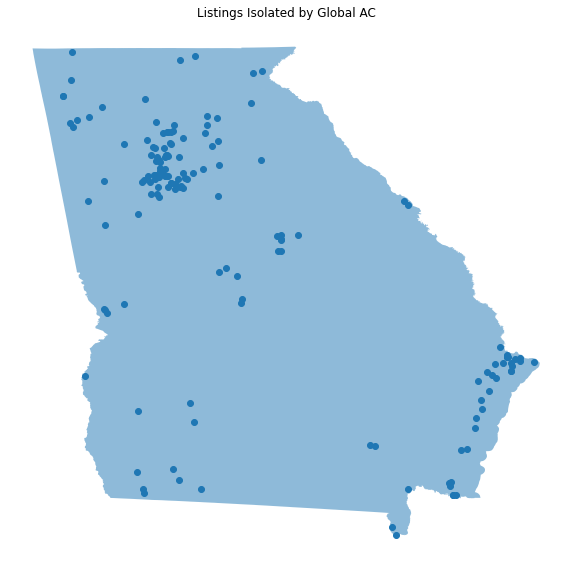

In [31]:
#Map all anomalies detected by global AC
aa_AC_noLL.map_anomalies(GA, title = 'Listings Isolated by Global AC')

## Visualize clusters

(-85.84627525, -80.54184975, 30.1234797, 35.2335803)

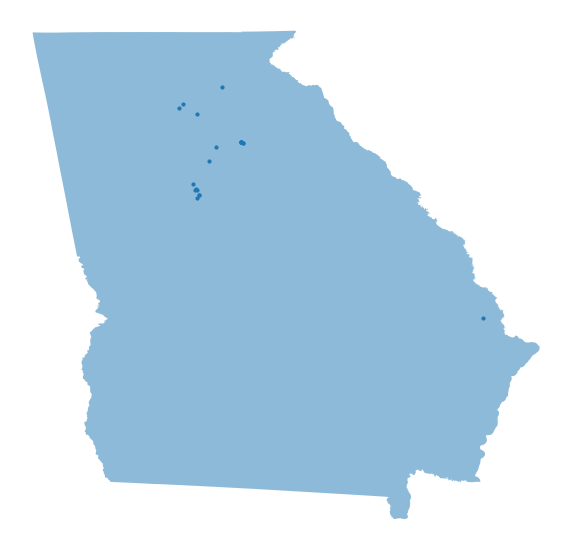

In [32]:
#Plot largest clusters
nth_largest = 2

fig, ax = plt.subplots(figsize = (10,10))
GApd.plot(ax = ax, alpha = .5)
places_to_geom(global_labeled[global_labeled['cluster'] 
                                  == global_sizes.iloc[nth_largest, 0]]).plot(ax = ax, markersize = 10)
plt.axis('off')

## PCA plots

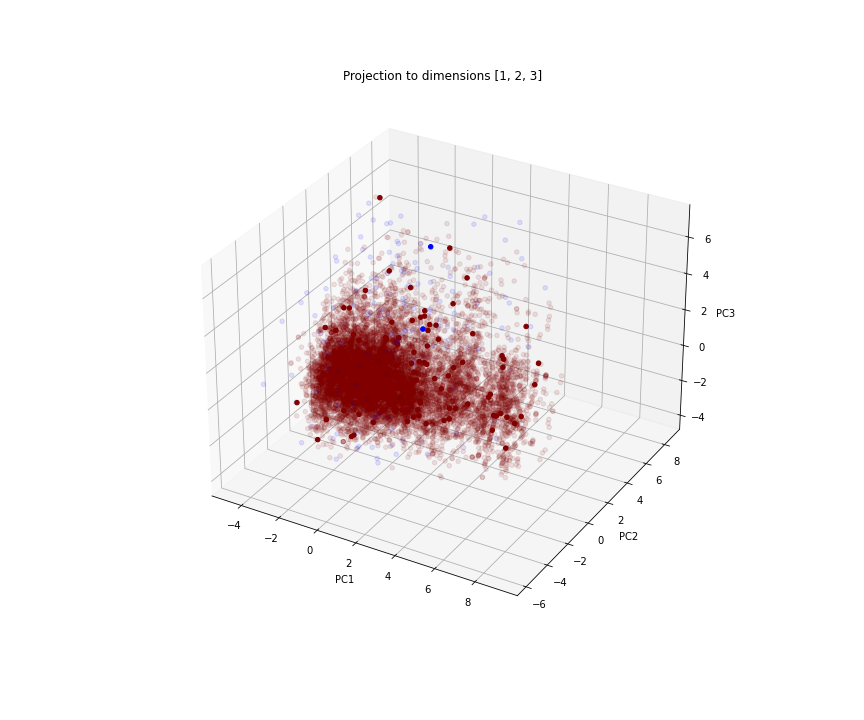

In [33]:
%matplotlib widget
#PCA plot with anomalies detected by Global AC highlighted
feature_grapher(aa_AC_noLL.data.filter(regex = 'PC'),[1,2,3], 
            c = color_anomalies(aa_AC_noLL),
            alpha = alpha_anomalies(aa_AC_noLL, anom_alpha = 1, nonanom_alpha = .1))

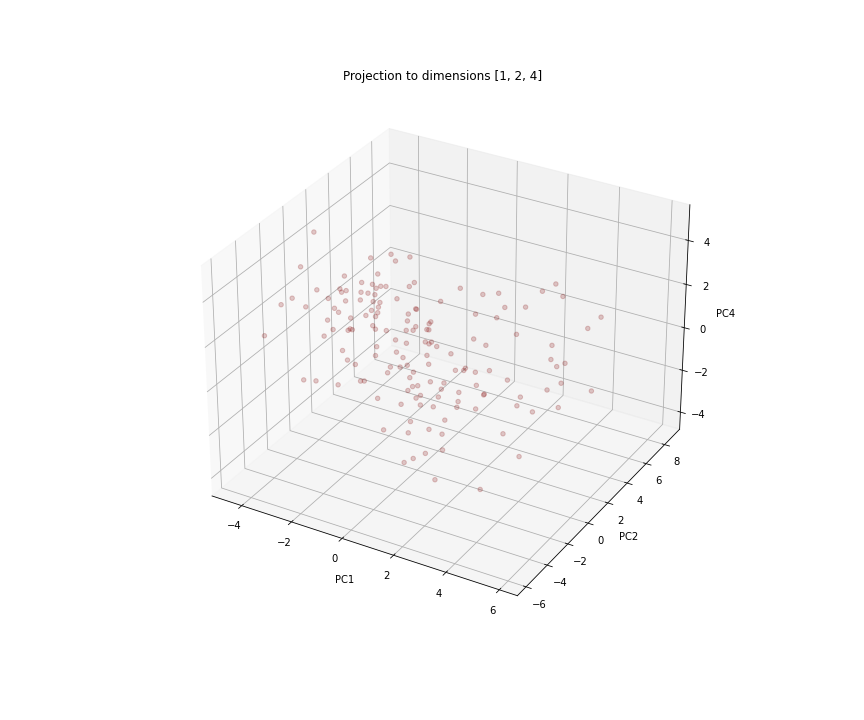

In [34]:
%matplotlib widget
#PCA plot of Global AC anomalies only
feature_grapher(aa_AC_noLL.anomalies.filter(regex = 'PC'),[1,2,4])

## Anomaly analysis (global)

In [35]:
%matplotlib inline

In [36]:
#Get those anomalies not detected by the Local AC (most of them)
global_anomalies = list(aa_AC_noLL.anomalies['data_idx'])
global_not_local = list(set(aa_AC_noLL.anomalies['data_idx'])\
                        .difference(set(aa_ac_local.anomalies['data_idx'])))

In [37]:
# fig,ax = plt.subplots(figsize = (10,10))
# GApd.plot(ax=ax, alpha = .5)
# places_to_geom(features.iloc[global_not_local,:]).plot(ax=ax, markersize = 10, alpha = .8)

In [38]:
#Pull example anomaly
ex_anom = global_not_local[7]
aa_AC_noLL.anomalies[aa_AC_noLL.anomalies.data_idx == ex_anom]

,data_idx,latitude,longitude,PC1,PC2,PC3,PC4,PC5,cluster
67,3085,34.041738,-84.437588,-0.649442,5.704581,1.209359,1.059532,0.721988,1552


In [39]:
#Look at differences between PC of anomaly and the mean of clusters containing one of the 10 most similar houses
differences = aa_AC_noLL.dif_from_clusters(ex_anom, 10)
aa_AC_noLL.get_all_loadings(differences)

Given point is in cluster 1552


cluster,323,403,971,1151,1453,2157,2230
square_footage,0.167921,0.684082,0.096140,0.521788,0.086938,0.216910,0.416642
posh_total,-0.073356,0.483803,-0.189372,0.208234,-0.377033,-0.086268,0.085688
dist_to_good_e_school,-0.249821,0.319244,-0.311659,-0.002489,-0.586898,-0.243513,-0.060935
property_crime_total_rate,-0.038194,0.565360,-0.122622,0.284014,-0.309385,-0.072840,0.123714
Transit Score,0.975882,0.199534,0.334396,0.436121,0.517853,0.408446,-0.106050
num_wb_within_5,0.034790,0.406805,0.187704,0.271707,0.233405,0.645798,0.969691
EAL_ratio,0.146690,0.428191,0.254066,0.322861,0.308814,0.647850,0.910313
dist_to_transit,0.270571,-0.404479,-0.331245,-0.079781,-0.061416,-0.200886,-0.715747
beds,-0.138516,0.329346,0.337147,0.177382,0.172499,-0.149690,0.149946
closest_school_rating,0.189413,0.496435,0.538565,0.515790,0.599633,0.074962,0.277879


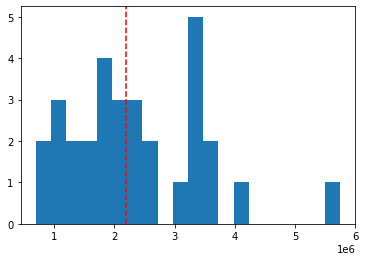

In [40]:
plt.hist(np.concatenate([aa_AC_noLL.cluster_price(x) for x in
 aa_AC_noLL.similar_point_clusters(ex_anom, n = 20)['cluster'].unique()]), bins = 20)
plt.axvline(x = aa_AC_noLL.house_price(ex_anom), color = 'red', linestyle ='--')

In [41]:
aa_AC_noLL.compare_price_to_similar(ex_anom, n=20)

-169764.12903225794

In [42]:
anom_price_comparison = pd.DataFrame([*zip(aa_AC_noLL.anomalies['data_idx'], aa_AC_noLL.anomalies['data_idx'].apply(lambda x:
    aa_AC_noLL.compare_price_to_similar(x, n=20)))]).rename({0:'anom_idx', 1:'price_comparison'}, axis = 1)

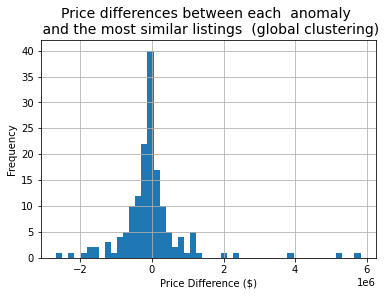

In [43]:
fig, ax = plt.subplots()
anom_price_comparison['price_comparison'].hist(bins= 50, ax = ax)
ax.set(xlabel = 'Price Difference ($)', ylabel = 'Frequency')
ax.set_title('Price differences between each  anomaly \n and the most similar listings  (global clustering)', fontsize = 14)
fig.savefig('price_dif_global.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

In [44]:
anom_price_comparison[anom_price_comparison.price_comparison<0].loc[:,'price_comparison'].sum()

-41551695.6493163

In [45]:
anom_price_comparison[anom_price_comparison.price_comparison>0].loc[:,'price_comparison'].sum()

39049459.32776341

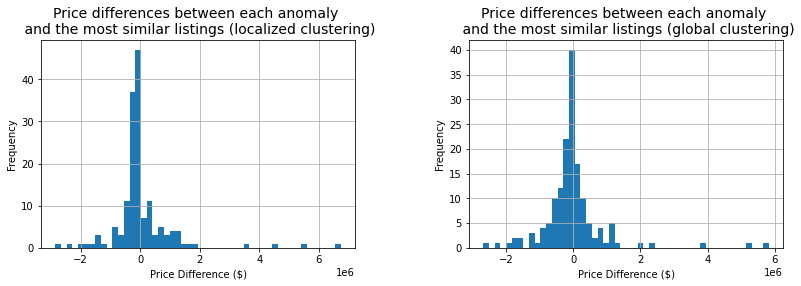

In [46]:
fig = plt.figure(figsize = (13,6))
ax1 = fig.add_subplot(121)
price_comparison_local['price_comparison'].hist(bins= 50, ax = ax1)
ax1.set(xlabel = 'Price Difference ($)', ylabel = 'Frequency')
ax1.set_title('Price differences between each anomaly \n and the most similar listings (localized clustering)', fontsize = 14)

ax2 = fig.add_subplot(122)
anom_price_comparison['price_comparison'].hist(bins= 50, ax = ax2)
ax2.set(xlabel = 'Price Difference ($)', ylabel = 'Frequency')
ax2.set_title('Price differences between each anomaly \n and the most similar listings (global clustering)', fontsize = 14)
fig.tight_layout(pad=8.0)
fig.savefig('price_differences_both.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

In [47]:
aa_AC_noLL.significantly_cheaper_than_similar_houses(n = 20)

[76, 107, 108, 1537, 5218, 5238]

In [48]:
aa_AC_noLL.dif_from_clusters(76, n=20)

Given point is in cluster 1331


cluster,402,447,1347,1510,1557,1831,2221
PC1,-0.971825,-0.240526,-1.158725,-1.433956,-0.023252,-0.274557,0.528659
PC2,-3.018527,-2.880150,-2.375943,-2.557180,-2.343645,-1.920499,-2.551321
PC3,0.619070,-0.666660,1.203903,-2.066094,0.709069,-0.254174,-1.983882
PC4,0.721156,-1.047541,0.563929,-1.126098,-0.721708,-1.854084,-0.164939
PC5,0.295293,-0.324345,0.260601,0.555108,0.010714,-1.956761,-0.005923


In [49]:
aa_AC_noLL.get_all_loadings(aa_AC_noLL.dif_from_clusters(76, n=20))

Given point is in cluster 1331


cluster,402,447,1347,1510,1557,1831,2221
square_footage,-0.911558,-1.470168,-0.543971,-1.620513,-0.904058,-1.125942,-1.510622
posh_total,-0.862420,-1.204633,-0.388886,-1.405060,-0.583579,-0.651856,-1.682172
dist_to_good_e_school,-0.805491,-0.910952,-0.344748,-1.127564,-0.378266,-0.253902,-1.526856
property_crime_total_rate,-0.934852,-1.317339,-0.451354,-1.581131,-0.652965,-0.748410,-1.750294
Transit Score,0.758184,-0.320918,0.706789,0.365115,0.001317,-1.720493,-0.058346
num_wb_within_5,-0.939782,-1.047116,-0.955666,-0.221101,-1.254503,-1.271877,-0.264007
EAL_ratio,-0.822688,-1.029561,-0.854111,-0.203544,-1.191982,-1.399341,-0.227234
dist_to_transit,1.177084,0.727467,1.232929,0.345114,0.990491,0.644929,-0.008003
beds,-0.585959,-0.310598,-0.586948,-0.797653,-0.263040,0.057319,-0.069529
closest_school_rating,-0.407470,-0.527308,-0.443232,-1.131230,-0.367997,-0.333810,-0.103791


In [50]:
aa_AC_noLL.similar_cluster_prices_median(76, n=20)

,cluster,price
0,402,308900.0
1,447,312000.0
2,1347,257700.0
3,1510,649900.0
4,1557,375000.0
5,1831,162700.0
6,2221,830000.0


In [51]:
aa_AC_noLL.house_price(76)

80000

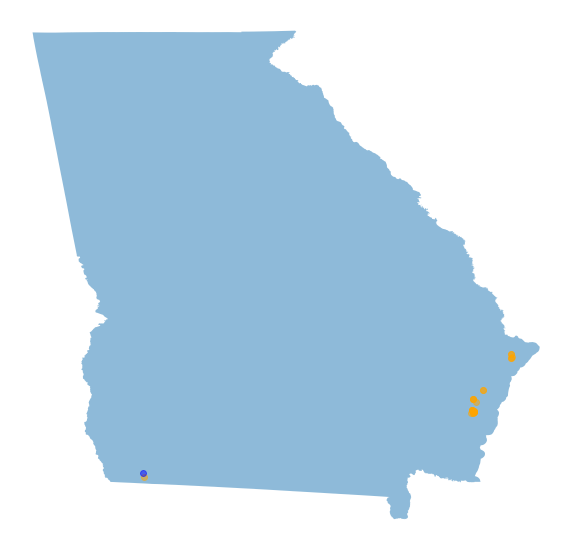

In [81]:
#Problem with this and many Global AC anomalies is that houses may be compared to far away clusters
#or other nearby isolates
# cluster = 2221
anomaly = 76
aa_AC_noLL.map_single_and_clusters(anomaly, [402, 447, 1347, 1510, 1557, 1831, 2221], GA)

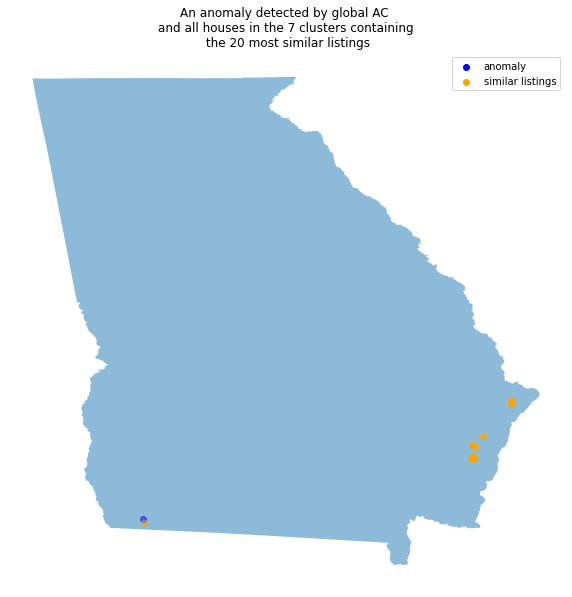

In [84]:
fig, ax = plt.subplots(figsize = (10,10))
GApd.plot(ax =ax, alpha = .5) #background
places_to_geom(pd.DataFrame(features.loc[76,:]).T).plot(ax = ax, color = 'blue', alpha = .5, label = 'anomaly')
places_to_geom(aa_AC_noLL.labeled_data[aa_AC_noLL.labeled_data.cluster.isin(
    [402, 447, 1347, 1510, 1557, 1831, 2221])]).plot(ax = ax, color = 'orange', alpha = .5, label = 'similar listings')
handles, labels = plt.gca().get_legend_handles_labels()
leg = ax.legend()
for lh in leg.legendHandles: 
    lh.set_alpha(1)

ax.set_title('An anomaly detected by global AC \n and all houses in the 7 clusters containing \n the 20 most similar listings')
ax.axis('off')
fig.savefig('anomaly_cluster_global.png', dpi = 320, bbox_inches = 'tight', pad_inches = .01)

In [ ]:


#Anomalies 
places_to_geom(aanalyz.anomalies).plot(ax = axis, markersize = 20, color = 'blue', alpha = .5, 
                                       label = 'anomalies')

#Reorder legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [3,2,1,0]
leg = axis.legend([handles[i] for i in order], [labels[i] for i in order], fontsize = 16)
#Set alpha values for legend to full for all artists
for lh in leg.legendHandles: 
    lh.set_alpha(1)

axis.axis('off') # no axes
#Set title
axis.set_title(title, fontsize = 28)

In [53]:
# labeled_data = ac_global_LL.data_with_labels()
# cluster_sizes = ac_global_LL.get_cluster_sizes()

In [54]:
# nth_largest = 5

# fig, ax = plt.subplots(figsize = (10,10))
# GApd.plot(ax = ax, alpha = .5)
# places_to_geom(labeled_data[labeled_data['cluster'] 
#                                   == cluster_sizes.iloc[nth_largest, 0]]).plot(ax = ax, markersize = 10)

# plt.xlim(-85.5,-80.5)
# plt.ylim(30,35.5)
# plt.axis('off')

In [55]:
# aa_AC_LL = AnomalyAnalyzer(ac_global_LL, features)

In [56]:
# aa_AC_LL.get_all_anomalies(1, 16, drop_imputed  = True)
# print(f'There are {aa_AC_LL.anomalies.shape[0]} anomalies with no imputed values.')

In [57]:
# %matplotlib inline
# fig,ax = plt.subplots(figsize = (10,10))
# GApd.plot(ax =ax, alpha = .5)
# places_to_geom(aa_AC_LL.anomalies).plot(ax = ax, markersize = 10)
# plt.axis('off')

In [58]:
# aa_AC_LL.labeled_data.loc[:,'latitude':'PC5']

In [59]:
# %matplotlib widget
# pca_grapher(aa_AC_LL.labeled_data.loc[:,'latitude':'PC5'],[1,2,7], c = color_anomalies(aa_AC_LL), alpha = alpha_anomalies(aa_AC_LL, anom_alpha = 1, nonanom_alpha = .1))

In [60]:
# pca_grapher(aa_AC_LL.anomalies.filter(regex='^PC'), [1,2,3])